# Pipelines
Le but de ce notebook est de créer diverses pipelines allant de la préparation des données à l'entraînement du modèle et de les comparer afin de déterminer la stratégie permettant d'obtenir le meilleur score sur l'ensemble de validation.

In [1]:
import pandas as pd
from utils import load_data, train_valid_test_split, PipelineEvaluator, evaluate
import estimators as est
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union

In [2]:
# Chargement des données
df = load_data("../data/train.txt")

# Découpage des données
df_train, df_valid, df_test = train_valid_test_split(df, size=(600, 200, 100))

X = df["text"]
X_train = df_train["text"]
y_train = df_train["language"]
X_valid = df_valid["text"]
y_valid = df_valid["language"]
X_test = df_test["text"]
y_test = df_test["language"]

# Pour grid search
X_cv = pd.concat([X_train, X_valid])
y_cv = pd.concat([y_train, y_valid])

# Évaluation des pipelines
peval = PipelineEvaluator(X_train, y_train, X_valid, y_valid)

# Baseline

In [3]:
pipe = make_pipeline(CountVectorizer(), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.6654162399577045

# Caractères
La correction des caractères spéciaux ne change pratiquement pas le score.

In [4]:
pipe = make_pipeline(est.SpecialCharsCorrector(), CountVectorizer(), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.6665963286741187

# Nombres
La tokenization des nombres n'a pratiquement aucun effet sur le score.

In [5]:
pipe = make_pipeline(est.NumbersTokenizer(), CountVectorizer(), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.6666167551065664

# CountVectorizer
On cherche à optimiser les paramètres de CountVectorizer.

In [6]:
pipe = make_pipeline(CountVectorizer(lowercase=False), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.6750873709348387

Ne pas passer en lowercase le texte permet de gagner environ 1 point de f1 score.

In [7]:
pipe = make_pipeline(CountVectorizer(stop_words="english"), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.6098206087166702

On a la preuve qu'il ne faut surtout pas enlever les stop words car cela fait perdre 5 points de f1 score.

In [8]:
pipe = make_pipeline(CountVectorizer(ngram_range=(1, 2)), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.7284038038419024

In [9]:
pipe = make_pipeline(CountVectorizer(lowercase=False, ngram_range=(1, 2)), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.7381868073768907

Utiliser des unigrammes et des bigrammes permet d'augmenter nettement le f1 score de 8 points par rapport à la baseline.

# TF-IDF
La méthode de vectorisation avec TF-IDF est plus performante que CountVectorizer.

In [10]:
pipe = make_pipeline(TfidfVectorizer(), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.7477890727462865

L'utilisation de TF-IDF semble améliorer la performance par rapport à CountVectorizer pour le modèle LinearSVC.

In [11]:
pipe = make_pipeline(TfidfVectorizer(lowercase=False), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.758081270859424

De la même manière que pour CountVectorizer passer en minuscule fait perdre de l'information.

In [12]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.7803852448311482

In [13]:
pipe = make_pipeline(TfidfVectorizer(lowercase=False, ngram_range=(1, 2)), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.7906081162181331

Encore une fois, utiliser des unigrammes et des bigrammes permet d'augmenter nettement le f1 score de 12 points par rapport à la baseline.

## Tokenizer
Le tokenizer de NLTK qui prend en compte la ponctuation permet de gagner 7 centièmes de score autrement dit rien.

In [14]:
pipe = make_pipeline(
    TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.gensim_tokenize, token_pattern=None), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.7946265397329081

In [15]:
pipe = make_pipeline(
    TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.7971896761336755

# Word2Vec
La vectorisation avec Word2Vec ne fonctionne pas du tout probablement car on perd trop d'information comme on fait une moyenne de vecteurs de mots pour chaque document.

In [16]:
# Méthode CBow sg=0
pipe = make_pipeline(
    est.SimpleTokenizer(), 
    est.Word2VecEstimator(min_count=1, vector_size=300, window=5, sg=0, workers=4), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.25891694137288085

In [17]:
pipe = make_pipeline(
    est.SimpleTokenizer(), 
    est.Word2VecEstimator(min_count=1, vector_size=500, window=5, sg=0, workers=4), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.27746111559769243

In [18]:
pipe = make_pipeline(
    est.SimpleTokenizer(), 
    est.Word2VecEstimator(min_count=10, vector_size=300, window=5, sg=0, workers=4), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.2608315462402077

In [19]:
# Méthode SkipGram sg=1
pipe = make_pipeline(
    est.SimpleTokenizer(), 
    est.Word2VecEstimator(min_count=1, vector_size=300, window=5, sg=1, workers=4), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.25891694137288085

In [20]:
pipe = make_pipeline(
    est.SimpleTokenizer(), 
    est.Word2VecEstimator(min_count=1, vector_size=500, window=5, sg=1, workers=4), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.27746111559769243

# Features
On suppose qu'ajouter des features permet d'aider le modèle.

## CountWords
On compte le nombre de mots par document.

In [21]:
pipe = make_pipeline(est.WordsCounter(), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

/home/maxime/Documents/maternal-language/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.02012967604952323

In [22]:
pipe = make_pipeline(est.WordsCounter(), StandardScaler(), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.05251379256905217

In [23]:
pipe = make_pipeline(est.WordsCounter(), MinMaxScaler(), LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.051687346288060425

In [24]:
pipe = make_pipeline(est.WordsCounter(), 
                     KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform'), 
                     LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.07131847814371083

In [25]:
pipe = make_pipeline(est.WordsCounter(), 
                     KBinsDiscretizer(n_bins=10, encode='onehot', strategy='quantile'), 
                     LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.08588585395748823

In [26]:
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None), 
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform'))),
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

!!! BEST !!!


0.8047768545298919

La feature du nombre de mots par document n'est pas significative. La discrétisation aide un peu le modèle à en tirer partie encore faut-il un nombre de bins suffisant. Utilisée en conjonction avec TfidfVectorizer cette feature n'a aucun effet (elle est noyée dans toutes les features).

## MeanCharsSentence
On compte le nombre moyen de caractères par phrase.

In [27]:
pipe = make_pipeline(
    est.MeanCharsSentence(), 
    KBinsDiscretizer(n_bins=10, encode='onehot', strategy='quantile'), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.11755210083174429

## MeanWordsSentence
On compte le nombre moyen de mots par phrase.

In [28]:
pipe = make_pipeline(
    est.MeanWordsSentence(), 
    KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile'), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.14804545554057816

# Richesse du vocabulaire
On compte le nombre de mots différents par document.

In [29]:
pipe = make_pipeline(
    est.LexicalRichness(), 
    KBinsDiscretizer(n_bins=25, encode='onehot', strategy='quantile'), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.11184299999549782

# Nombre de consonnes doublées

In [30]:
pipe = make_pipeline(
    est.DoubleConsonantCounter(), 
    KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile'), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.08554369140363884

# Nombre de contractions

In [31]:
pipe = make_pipeline(
    est.ContractionsCounter(),
    KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'), 
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.05738261881697837

# Concaténation des features
Le fait de combiner les features permet bien d'avoir plus d'information mais ces features ne sont pas suffisamment siginificatives. Elles font même baisser le score du modèle. Peut-être est-il temps d'optimiser le modèle ?

In [32]:
# Features seules
pipe = make_pipeline(
    make_union(
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.18336790524145197

In [33]:
# On ajoute la vectorisation
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    LinearSVC(random_state=42, max_iter=1500))
peval.evaluate(pipe)

0.7926774632982265

# Modèles
## LinearSVC
On va utiliser une RandomGridSearch afin d'optimiser les hyperparamètres du modèle LinearSVC. Malheureusment c'est insuffisant pour gagner en score.

In [34]:
"""
%%time
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

param_grid = [
    {'penalty': ['l1', 'l2']},
    {'loss': ['hinge', 'squared_hinge']},
    {'dual': [True, False]},
    {'multi_class':['ovr', 'crammer_singer']},
    {'max_iter': [500, 1500, 3000, 5000]},
    {'C': [1., 5., 10., 50., 100.]},
    {'tol': [1e-4, 1e-3, 1e-2, 1e-1]}
]

# Supprimer les erreurs de combinaisons illégales
with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]): 
    pipe = make_pipeline(
        make_union(
            TfidfVectorizer(lowercase=False, ngram_range=(1, 2)),
            make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
            make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
            make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
            make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
        GridSearchCV(LinearSVC(), cv=5, scoring='f1_macro', n_jobs=-2, verbose=1, param_grid=param_grid))

pipe.fit(X_cv, y_cv)
print(pipe.named_steps["gridsearchcv"].best_params_)
"""
print()

## Compression des features
On essaye de réduire le nombre de features avec TruncatedSVD. Malheureusement, le modèle a du mal à performer avec les features restantes. Le temps de réduction de la dimension est assez élevé si on choisi un nombre de components élevé.

|n_components|score|
|-|-|
|10|0.11|
|100|0.48|
|1000|0.72|

In [35]:
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    TruncatedSVD(n_components=10),
    LinearSVC(penalty='l2', loss='squared_hinge', max_iter=500))
peval.evaluate(pipe)

0.11252488097405569

Jusque là on a uniquement utilisé le LinearSVC. On va maintenant essayer d'autres modèles.

## RandomForestClassifier

In [36]:
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    RandomForestClassifier(n_estimators=100, max_features='log2', n_jobs=-2))
peval.evaluate(pipe)

0.3687031829011474

In [37]:
pipe.score(X_train, y_train)

1.0

On est en situation d'overfitting avec le RandomForestClassifier. Nous avons essayé différents hyperparamètres mais le score monte difficilement. Ce modèle ne semble pas adapté au dataset.

|hyperparamètres|score|
|-|-|
|n_estimators=500|0.57|
|n_estimators=100, max_depth=1|0.27|
|max_depth=2|0.35|
|max_depth=4|0.41|
|max_depth=6|0.42|
|max_depth=10|0.47|
|max_depth=None|0.46|
|criterion='entropy'|0.43|
|criterion='log_loss'|0.40|
|min_samples_split=5|0.487|
|min_samples_split=10|0.49|
|min_samples_split=25|0.51|
|min_samples_leaf=10|0.51|
|max_features='log2'|0.36|

## SVC

In [38]:
from sklearn.svm import SVC
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    SVC())
peval.evaluate(pipe)

0.2812122106516718

## LogisticRegression

In [39]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    LogisticRegression())
peval.evaluate(pipe)

/home/maxime/Documents/maternal-language/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.616538317001623

## SGDClassifier

In [40]:
from sklearn.linear_model import SGDClassifier
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    SGDClassifier())
peval.evaluate(pipe)

0.7569064120383594

## KNeighborsClassifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
pipe = make_pipeline(
    make_union(
        TfidfVectorizer(lowercase=False, ngram_range=(1, 2), tokenizer=est.nltk_tokenize, token_pattern=None),
        make_pipeline(est.WordsCounter(), KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')),
        make_pipeline(est.MeanWordsSentence(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.DoubleConsonantCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='quantile')),
        make_pipeline(est.ContractionsCounter(), KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform'))),
    KNeighborsClassifier())
peval.evaluate(pipe)

0.1739270722440685

Aucun des autres modèles testés ne surpasse le LinearSVC bien que le SGDClassifier soit assez proche.

## Évaluation finale

accuracy: 0.8018181818181818
f1-score: 0.8018630416852779


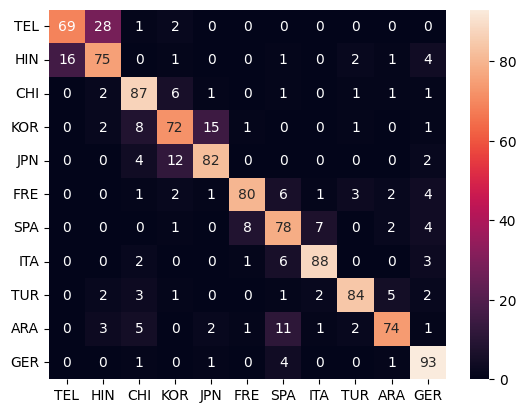

In [42]:
pipe = make_pipeline(
    est.SpecialCharsCorrector(),
    est.NumbersTokenizer(),
    TfidfVectorizer(lowercase=False, ngram_range=(1, 2), 
                    tokenizer=est.nltk_tokenize, token_pattern=None),
    LinearSVC(random_state=42, max_iter=3000, C=2.))

pipe.fit(X_cv, y_cv)
y_pred = pipe.predict(X_test)
evaluate(y_test, y_pred)